# Imports and Helper functions

In [69]:
import numpy as np
import librosa
from util import play_audio, load_audio, get_features, get_mfcc, get_lmfe, get_chroma, plot_chroma, plot_mfcc, plot_lmfe
from tqdm.notebook import trange, tqdm
import pandas as pd
import glob
import scipy
from sklearn.metrics import roc_auc_score, recall_score, precision_score, roc_curve
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
%matplotlib inline  

import seaborn as sns

sns.set(style="white", palette="muted")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
def convert_complex_to_real(value):
    return complex(value).real

def printmd(string):
    display(Markdown(string))
    
def get_df_feat(df, n_fft, sr, means=False):
    ''' Used to extract Features from spectrograms 
    MFCC, Log mel energy and Chroma (CENS)
    '''
    feat_cols = []

    # Initialize the progress bar
    progress_bar = tqdm(total=len(df), position=0, leave=True)
    for i, row in df.iterrows():
        filename = row['filename']
        feat, labels = get_features(filename, n_fft, sr, frac=10, means=means)

        feat_cols.append(feat)
        lab_cols = labels
        # Update the progress bar
        progress_bar.update(1)

    feat_array = np.vstack(feat_cols)
    lab_array = lab_cols.flatten()

    feat_df = pd.DataFrame(feat_array, columns=list(lab_array), index=df.index)

    # Convert complex numbers to real values
    feat_df = feat_df.applymap(convert_complex_to_real)

    # Assign the columns to the original DataFrame
    df = pd.concat([df, feat_df], axis=1)

    return df

In [72]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def classify_anomalies(train_data, test_data, test_labels, machine, feat_label):
    scaler = MinMaxScaler((-5, 5))
    
    # LOF without PCA
    lof = LocalOutlierFactor(novelty=True, contamination=0.0001)
    lof_pipe = Pipeline([("scaler", scaler), ("classifier", lof)])
    
    # LOF with PCA
    pca_lof = PCA(0.9)
    lof_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_lof), ("classifier", lof)])
    
    # Isolation Forest without PCA
    isolation_forest = IsolationForest(contamination=0.0001)
    isolation_forest_pipe = Pipeline([("scaler", scaler), ("classifier", isolation_forest)])
    
    # Isolation Forest with PCA
    pca_if = PCA(0.9)
    isolation_forest_pca_pipe = Pipeline([("scaler", scaler), ("pca", pca_if), ("classifier", isolation_forest)])

    models = {
        "LOF": lof_pipe,
        "LOF + PCA": lof_pca_pipe,
        "Isolation Forest": isolation_forest_pipe,
        "Isolation Forest + PCA": isolation_forest_pca_pipe,
    }

    results = {
        "Machine": machine,
        "Features": feat_label,
        "Model": [],
        "AUC": [],
        "Recall": [],
        "Precision": [],
        "Abnormal (-1) F1": [],
    }
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(16, 4))

    for i, (model_name, model) in enumerate(models.items()):
        roc_ax = axes[i]
        model.fit(train_data)
        scores = model.decision_function(test_data)
        auc = roc_auc_score(test_labels, scores)  # Use -scores because higher score should be less anomalous
        fpr, tpr, thresholds = roc_curve(test_labels, scores)
        # Plot the ROC curve
        roc_ax.plot(fpr, tpr)
        roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', alpha=0.7)  # Diagonal line for reference
        roc_ax.set_title(f'{model_name}\n ROC Curve\n AUC = {auc:.2f}')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(['ROC curve', 'Random'], fontsize="9", loc='lower right')

        # Sort scores in ascending order and find the threshold for 85% correctly classified normal data
        sorted_scores = np.sort(thresholds)
        threshold_index = int(0.85 * len(sorted_scores))
        threshold = sorted_scores[threshold_index]

        # Make predictions based on the threshold
        predictions = np.where(scores >= threshold, 1, -1)
        recall = recall_score(test_labels, predictions, average='weighted')
        precision = precision_score(test_labels, predictions, average='weighted')
        abf1 = metrics.f1_score(test_labels, predictions, pos_label= -1, average='binary')

        results["Model"].append(model_name)
        results["AUC"].append(auc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["Abnormal (-1) F1"].append(abf1)

    results_df = pd.DataFrame(results)
    print(f"{feat_label} features were reduced to {pca_lof.n_components_} components for LOF")
    print(f"{feat_label} features were reduced to {pca_if.n_components_} components for Isolation Forest")
    return results_df




# Get features (no mean)

In [5]:
df = pd.read_pickle('working/df.pkl')

In [6]:
df['type'] = df['filename'].apply(lambda x: x.split('/')[1])

In [7]:
df_fan = df[df['type'] == 'fan'].copy()
df_valve = df[df['type'] == 'valve'].copy()

In [8]:
df_fan = get_df_feat(df_fan, n_fft=2048, sr=16000)

  0%|          | 0/5550 [00:00<?, ?it/s]

In [9]:
df_valve = get_df_feat(df_valve, n_fft=2048, sr=16000)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [142]:
# df_valve.to_pickle('working/df_valve.pkl')
# df_fan.to_pickle('working/df_fan.pkl')

df_valve =  pd.read_pickle('working/df_valve.pkl')
df_fan =  pd.read_pickle('working/df_fan.pkl')

In [94]:
df_fan.columns = df_fan.columns.str.replace('_', ' ').astype('str')
df_valve.columns = df_valve.columns.str.replace('_', ' ').astype('str')

In [95]:
valcols = df_valve.columns[8:]
valcols

Index(['lmfe2 1', 'lmfe2 2', 'lmfe2 3', 'lmfe2 4', 'lmfe2 5', 'lmfe2 6',
       'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       ...
       'chroma2 304', 'chroma2 305', 'chroma2 306', 'chroma2 307',
       'chroma2 308', 'chroma2 309', 'chroma2 310', 'chroma2 311',
       'chroma2 312', 'chroma2 313'],
      dtype='object', length=3002)

In [96]:
chroma_only = [col for col in valcols if col.startswith('chroma')]
mel_only = [col for col in valcols if col.startswith('mf') or col.startswith('lm')]

In [97]:
fancols = df_fan.columns[8:]
fancols

Index(['lmfe2 1', 'lmfe2 2', 'lmfe2 3', 'lmfe2 4', 'lmfe2 5', 'lmfe2 6',
       'lmfe2 7', 'lmfe2 8', 'lmfe2 9', 'lmfe2 10',
       ...
       'chroma2 304', 'chroma2 305', 'chroma2 306', 'chroma2 307',
       'chroma2 308', 'chroma2 309', 'chroma2 310', 'chroma2 311',
       'chroma2 312', 'chroma2 313'],
      dtype='object', length=3002)

## Valve

In [98]:
train_data = df_valve[df_valve['train'] == 1]
test_data = df_valve[df_valve['test'] == 1]
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

mel features were reduced to 444 components for LOF
mel features were reduced to 444 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | mel        | LOF                    | 0.481517 | 0.199804 |    0.763484 |           0.199542 |
|  1 | valve     | mel        | LOF + PCA              | 0.367448 | 0.147482 |    0.625274 |           0.180446 |
|  2 | valve     | mel        | Isolation Forest       | 0.448704 | 0.168411 |    0.710928 |           0.192442 |
|  3 | valve     | mel        | Isolation Forest + PCA | 0.251751 | 0.128188 |    0.544879 |           0.181707 |


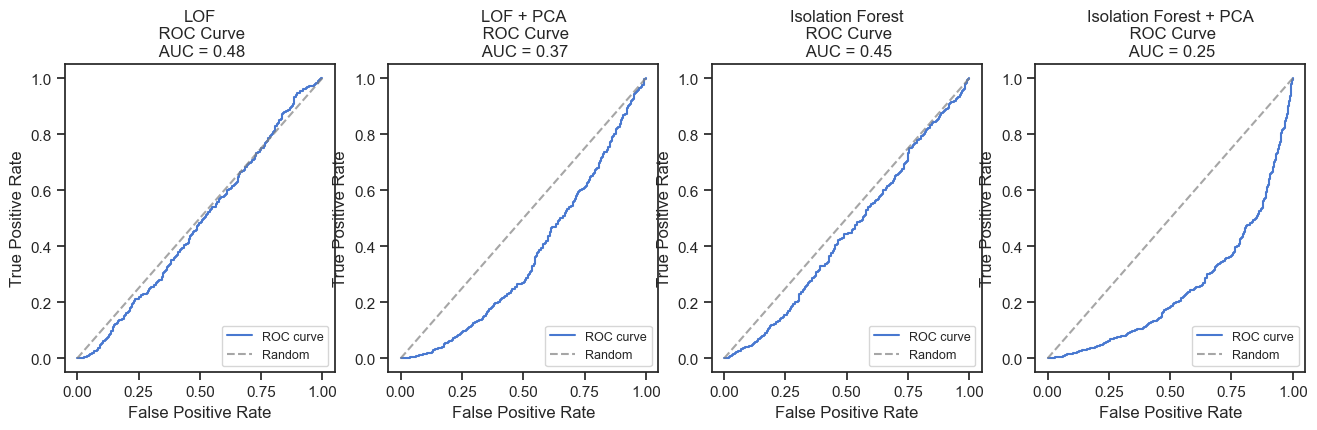

In [99]:
valve_mel = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'valve', 'mel')
print(valve_mel.to_markdown())

chroma features were reduced to 12 components for LOF
chroma features were reduced to 12 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | chroma     | LOF                    | 0.48245  | 0.228254 |    0.79435  |           0.206989 |
|  1 | valve     | chroma     | LOF + PCA              | 0.489762 | 0.22433  |    0.788256 |           0.205094 |
|  2 | valve     | chroma     | Isolation Forest       | 0.559791 | 0.297907 |    0.82648  |           0.221819 |
|  3 | valve     | chroma     | Isolation Forest + PCA | 0.488162 | 0.246893 |    0.803474 |           0.209949 |


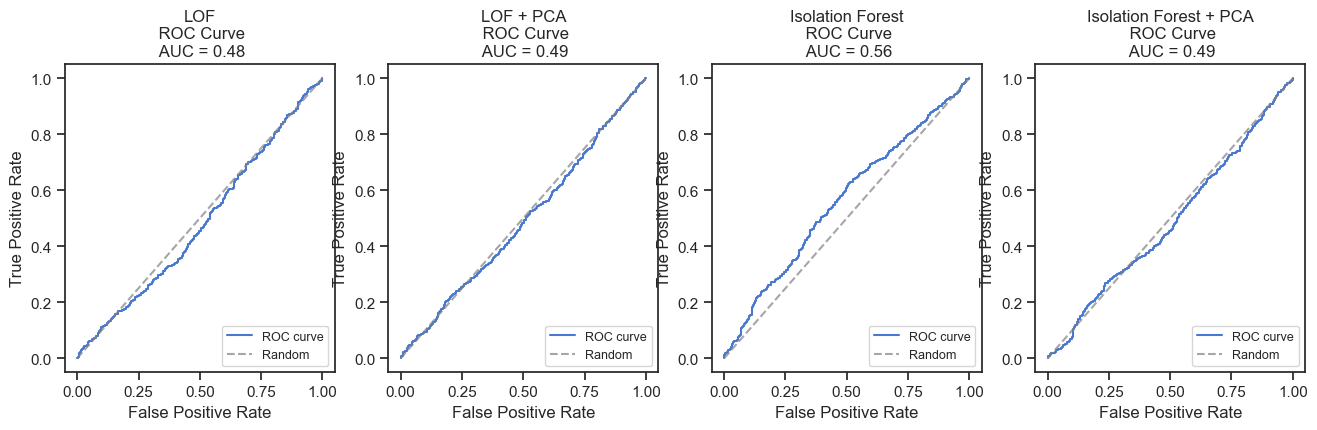

In [102]:
valve_chroma = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'valve', 'chroma')
print(valve_chroma.to_markdown())

All features were reduced to 380 components for LOF
All features were reduced to 380 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All        | LOF                    | 0.521722 | 0.23087  |    0.785656 |           0.203791 |
|  1 | valve     | All        | LOF + PCA              | 0.422666 | 0.16743  |    0.688931 |           0.186581 |
|  2 | valve     | All        | Isolation Forest       | 0.480823 | 0.218116 |    0.7832   |           0.203796 |
|  3 | valve     | All        | Isolation Forest + PCA | 0.259254 | 0.129823 |    0.546213 |           0.177943 |


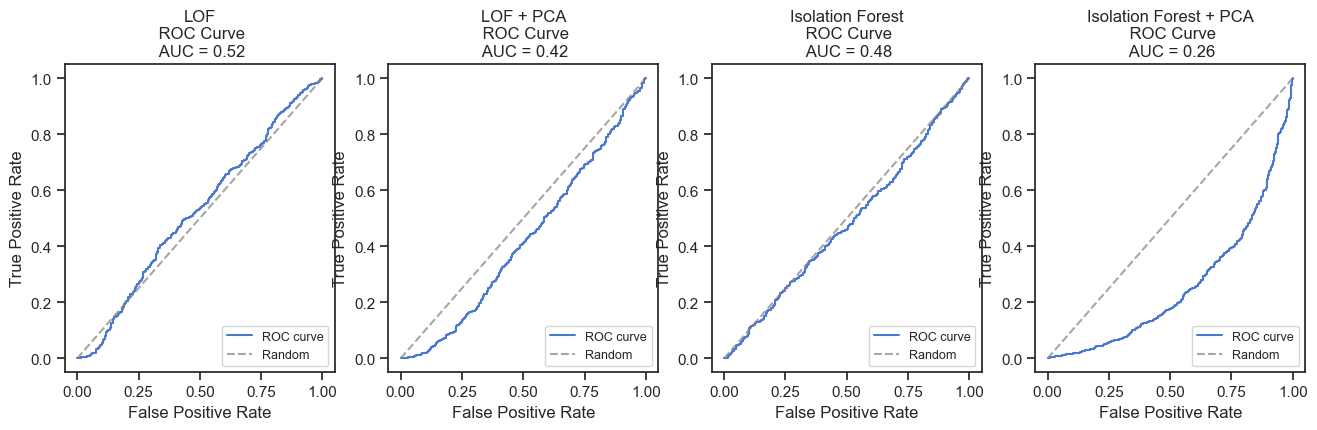

In [103]:
valve_allF = classify_anomalies(train_data[valcols], test_data[valcols], y_val, 'valve', 'All')
print(valve_allF.to_markdown())

## Fan

In [104]:
train_data = df_fan[df_fan['train'] == 1]
test_data = df_fan[df_fan['test'] == 1]
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

mel features were reduced to 450 components for LOF
mel features were reduced to 450 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | mel        | LOF                    | 0.947371 | 0.83517  |    0.885866 |           0.756201 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | mel        | LOF + PCA              | 0.822146 | 0.459272 |    0.762866 |           0.479834 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | mel        | Isolation Forest       | 0.765178 | 0.530906 |    0.7

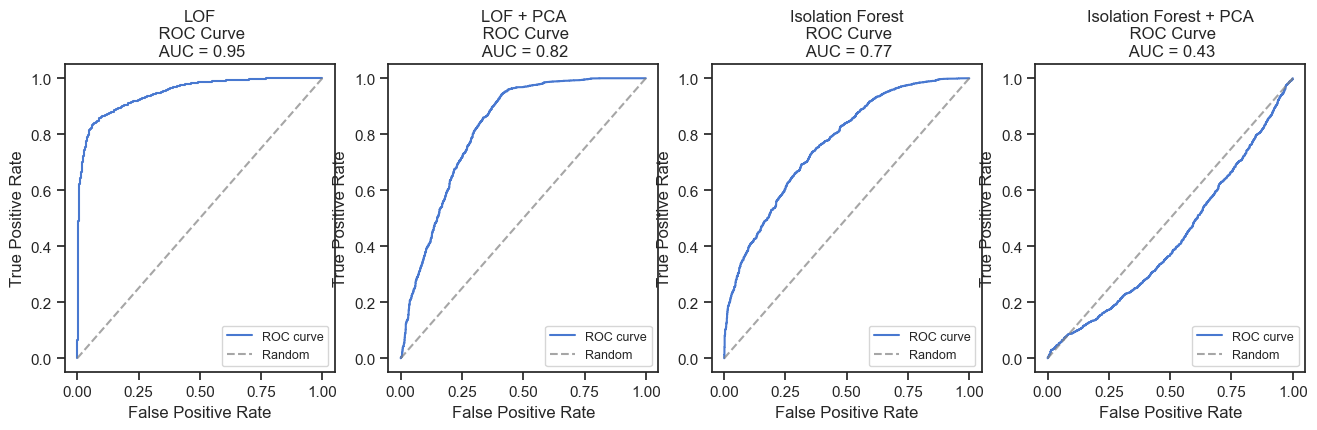

In [105]:
fan_mel = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'fan', 'mel')
print(fan_mel.to_markdown(tablefmt="grid"))

chroma features were reduced to 14 components for LOF
chroma features were reduced to 14 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | chroma     | LOF                    | 0.607283 | 0.408241 |    0.691418 |           0.439909 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | chroma     | LOF + PCA              | 0.604356 | 0.399856 |    0.6856   |           0.436445 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | chroma     | Isolation Forest       | 0.658335 | 0.443939 |   

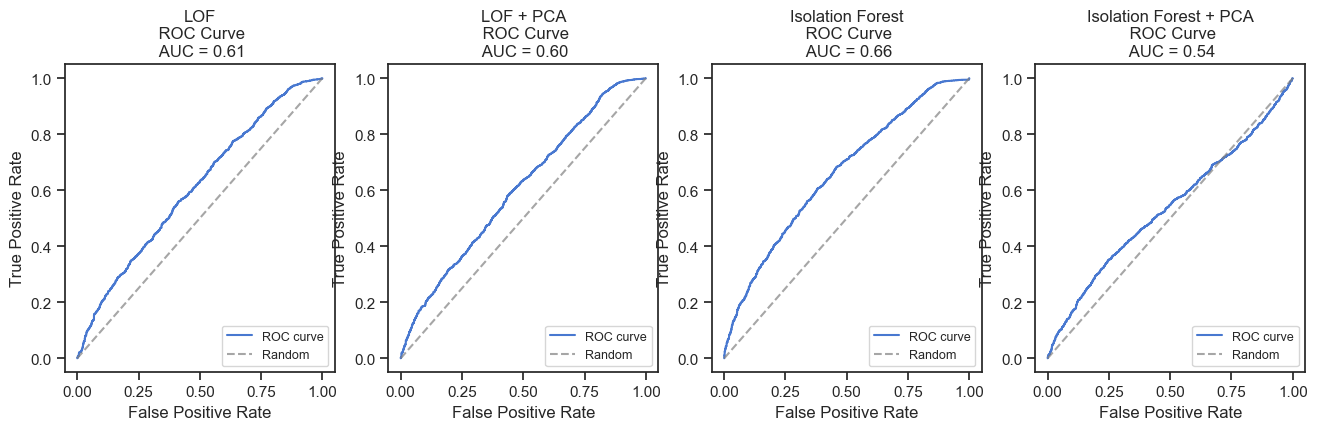

In [106]:
fan_chroma = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'fan', 'chroma')
print(fan_chroma.to_markdown(tablefmt="grid"))

All features were reduced to 389 components for LOF
All features were reduced to 389 components for Isolation Forest
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
+====+===========+============+========================+==========+==========+=============+====================+
|  0 | fan       | All        | LOF                    | 0.925636 | 0.775515 |    0.860069 |           0.692888 |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  1 | fan       | All        | LOF + PCA              | 0.834264 | 0.513177 |    0.776162 |           0.50439  |
+----+-----------+------------+------------------------+----------+----------+-------------+--------------------+
|  2 | fan       | All        | Isolation Forest       | 0.747226 | 0.535937 |    0.7

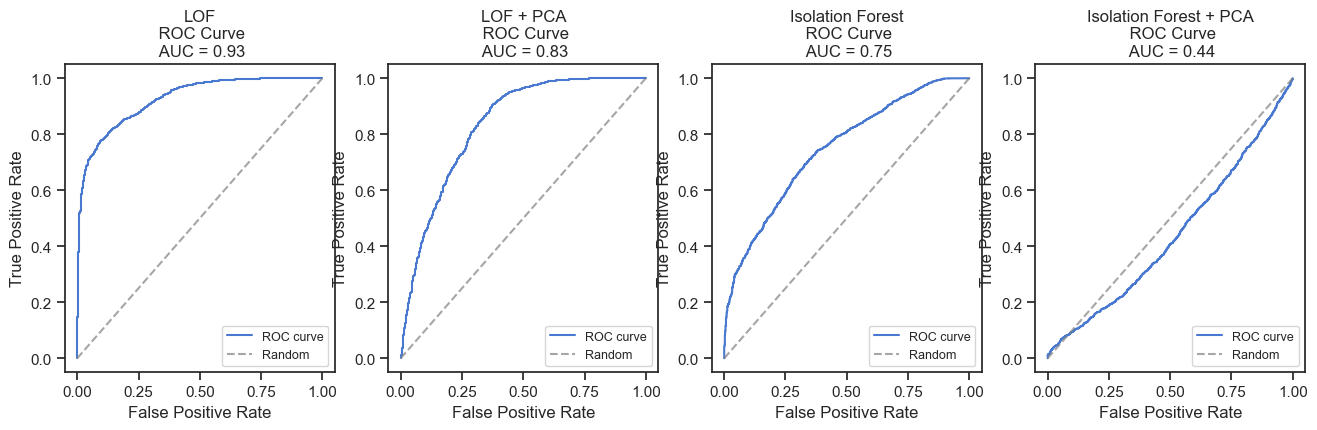

In [107]:
fan_allF = classify_anomalies(train_data[fancols], test_data[fancols], y_val, 'fan', 'All')
print(fan_allF.to_markdown(tablefmt="grid"))

# Get features (means over time axis)
### i.e. the mean for each chroma, mfcc and log mel energy filterbank 

In [5]:
df = pd.read_pickle('working/df.pkl')

In [6]:
df['type'] = df['filename'].apply(lambda x: x.split('/')[1])

In [7]:
df_fan = df[df['type'] == 'fan'].copy()
df_valve = df[df['type'] == 'valve'].copy()

In [8]:
df_fan = get_df_feat(df_fan, n_fft=2048, sr=16000, means=True)

  0%|          | 0/5550 [00:00<?, ?it/s]

In [9]:
df_valve = get_df_feat(df_valve, n_fft=2048, sr=16000, means=True)

  0%|          | 0/4170 [00:00<?, ?it/s]

In [41]:
# df_valve.to_pickle('working/df_valve_means.pkl')
# df_fan.to_pickle('working/df_fan_means.pkl')

In [77]:
df_valve =  pd.read_pickle('working/df_valve_means.pkl')
df_fan =  pd.read_pickle('working/df_fan_means.pkl')

In [80]:
valcols = df_valve.drop('recording', axis=1).columns[8:]
valcols

Index(['lmfe1', 'lmfe2', 'lmfe3', 'lmfe4', 'lmfe5', 'lmfe6', 'lmfe7', 'lmfe8',
       'lmfe9', 'lmfe10', 'lmfe11', 'lmfe12', 'lmfe13', 'lmfe14', 'lmfe15',
       'lmfe16', 'lmfe17', 'lmfe18', 'lmfe19', 'lmfe20', 'lmfe21', 'lmfe22',
       'lmfe23', 'lmfe24', 'lmfe25', 'lmfe26', 'lmfe27', 'lmfe28', 'lmfe29',
       'lmfe30', 'lmfe31', 'lmfe32', 'lmfe33', 'lmfe34', 'lmfe35', 'lmfe36',
       'lmfe37', 'lmfe38', 'lmfe39', 'lmfe40', 'lmfe41', 'lmfe42', 'lmfe43',
       'lmfe44', 'lmfe45', 'lmfe46', 'lmfe47', 'lmfe48', 'lmfe49', 'lmfe50',
       'lmfe51', 'lmfe52', 'lmfe53', 'lmfe54', 'lmfe55', 'lmfe56', 'lmfe57',
       'lmfe58', 'lmfe59', 'lmfe60', 'lmfe61', 'lmfe62', 'lmfe63', 'lmfe64',
       'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'chroma1', 'chroma2', 'chroma3',
       'chroma4', 'chroma5', 'chroma6', 'chroma7', 'chroma8', 'chroma9',
       'chroma10', 'chroma11', 'chroma12'],
      dtype='object')

In [81]:
chroma_only = [col for col in valcols if col.startswith('chroma')]
mel_only = [col for col in valcols if col.startswith('mf') or col.startswith('lm')]

In [82]:
fancols = df_fan.drop('recording', axis=1).columns[8:]
fancols

Index(['lmfe1', 'lmfe2', 'lmfe3', 'lmfe4', 'lmfe5', 'lmfe6', 'lmfe7', 'lmfe8',
       'lmfe9', 'lmfe10', 'lmfe11', 'lmfe12', 'lmfe13', 'lmfe14', 'lmfe15',
       'lmfe16', 'lmfe17', 'lmfe18', 'lmfe19', 'lmfe20', 'lmfe21', 'lmfe22',
       'lmfe23', 'lmfe24', 'lmfe25', 'lmfe26', 'lmfe27', 'lmfe28', 'lmfe29',
       'lmfe30', 'lmfe31', 'lmfe32', 'lmfe33', 'lmfe34', 'lmfe35', 'lmfe36',
       'lmfe37', 'lmfe38', 'lmfe39', 'lmfe40', 'lmfe41', 'lmfe42', 'lmfe43',
       'lmfe44', 'lmfe45', 'lmfe46', 'lmfe47', 'lmfe48', 'lmfe49', 'lmfe50',
       'lmfe51', 'lmfe52', 'lmfe53', 'lmfe54', 'lmfe55', 'lmfe56', 'lmfe57',
       'lmfe58', 'lmfe59', 'lmfe60', 'lmfe61', 'lmfe62', 'lmfe63', 'lmfe64',
       'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'chroma1', 'chroma2', 'chroma3',
       'chroma4', 'chroma5', 'chroma6', 'chroma7', 'chroma8', 'chroma9',
       'chroma10', 'chroma11', 'chroma12'],
      dtype='object')

In [83]:
df_fan['recording'] = df_fan['label'].replace({-1 : 'abnormal', 1 : 'normal'})
df_valve['recording'] = df_valve['label'].replace({-1 : 'abnormal', 1 : 'normal'})

***
#### Plot chroma means

In [63]:
mapping_dict = {f'chroma{i}': pitch for i, pitch in enumerate(['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'], 1)}
df = pd.concat([df_fan, df_valve], ignore_index=True) 

In [64]:
df_chroma = pd.melt(df, id_vars=['filename', 'label', 'type', 'model', 'recording'], value_vars=chroma_only, var_name='chroma', value_name='cens')

In [65]:
df_chroma['notes'] = df_chroma['chroma'].replace(mapping_dict)

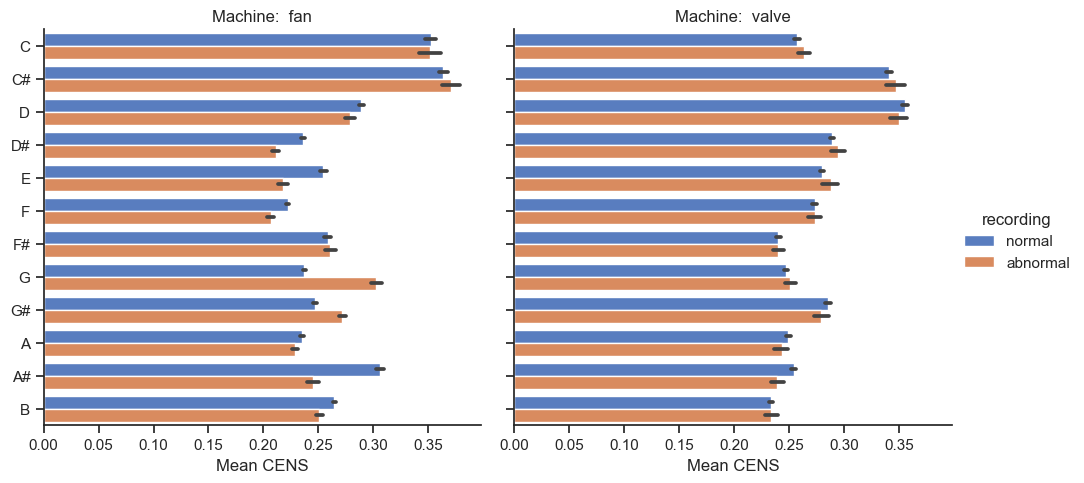

In [154]:
g = sns.catplot(data=df_chroma, x="cens", y="notes", hue="recording", kind="bar", col='type')
g.set_axis_labels("Mean CENS", "")

g.set_titles("Machine:  {col_name}")
g.savefig("figs/mean_cens.png", transparent=True, dpi=400)

plt.show()

## Valve

In [84]:
train_data = df_valve[df_valve['train'] == 1]
test_data = df_valve[df_valve['test'] == 1]
y_val = df_valve[(df_valve["test"] == 1)]['label'].tolist()

mel-means features were reduced to 16 components for LOF
mel-means features were reduced to 16 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | mel-means  | LOF                    | 0.666815 | 0.402551 |    0.859777 |           0.25641  |
|  1 | valve     | mel-means  | LOF + PCA              | 0.618747 | 0.339111 |    0.839748 |           0.233017 |
|  2 | valve     | mel-means  | Isolation Forest       | 0.533142 | 0.24722  |    0.798072 |           0.207846 |
|  3 | valve     | mel-means  | Isolation Forest + PCA | 0.51853  | 0.262917 |    0.81337  |           0.214086 |


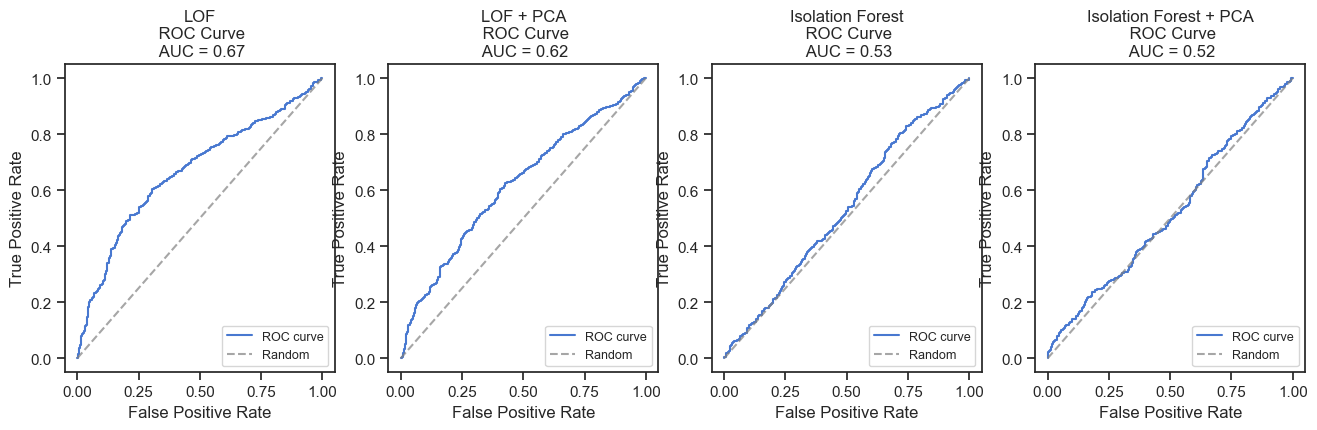

In [85]:
valve_mel_means = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'valve', 'mel-means')
print(valve_mel_means.to_markdown())

chroma-means features were reduced to 9 components for LOF
chroma-means features were reduced to 9 components for Isolation Forest
|    | Machine   | Features     | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | chroma-means | LOF                    | 0.575024 | 0.292675 |    0.83062  |           0.223339 |
|  1 | valve     | chroma-means | LOF + PCA              | 0.582245 | 0.288097 |    0.827776 |           0.221666 |
|  2 | valve     | chroma-means | Isolation Forest       | 0.52673  | 0.226946 |    0.793395 |           0.206711 |
|  3 | valve     | chroma-means | Isolation Forest + PCA | 0.527152 | 0.226619 |    0.786924 |           0.204507 |


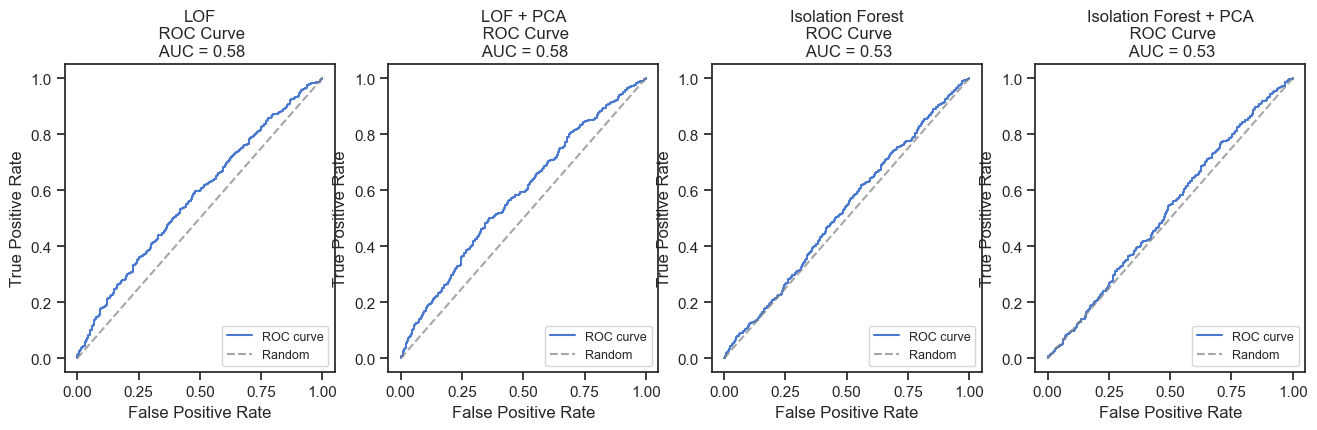

In [86]:
valve_chroma_means = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'valve', 'chroma-means')
print(valve_chroma_means.to_markdown())

All-means features were reduced to 22 components for LOF
All-means features were reduced to 22 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All-means  | LOF                    | 0.665219 | 0.414323 |    0.859019 |           0.258385 |
|  1 | valve     | All-means  | LOF + PCA              | 0.641049 | 0.362982 |    0.851031 |           0.243201 |
|  2 | valve     | All-means  | Isolation Forest       | 0.533533 | 0.249509 |    0.812146 |           0.213233 |
|  3 | valve     | All-means  | Isolation Forest + PCA | 0.507189 | 0.234467 |    0.797146 |           0.207783 |


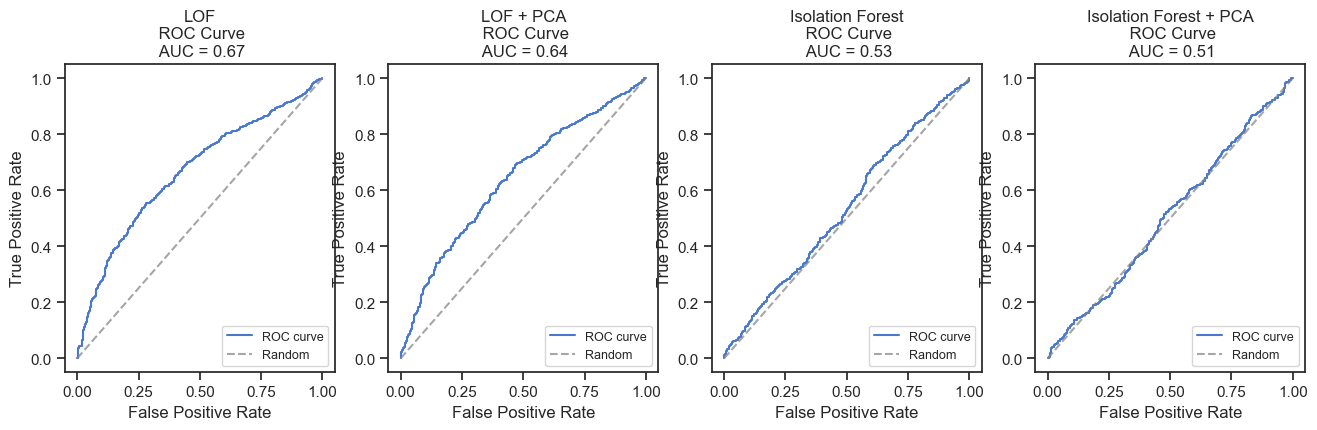

In [87]:
valve_allF_means = classify_anomalies(train_data[valcols], test_data[valcols], y_val, 'valve', 'All-means')
print(valve_allF_means.to_markdown())

## Fan

In [88]:
train_data = df_fan[df_fan['train'] == 1]
test_data = df_fan[df_fan['test'] == 1]
y_val = df_fan[(df_fan["test"] == 1)]['label'].tolist()

mel-means features were reduced to 4 components for LOF
mel-means features were reduced to 4 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | mel-means  | LOF                    | 0.994428 | 0.927887 |    0.94199  |           0.880223 |
|  1 | fan       | mel-means  | LOF + PCA              | 0.971192 | 0.735985 |    0.857458 |           0.663614 |
|  2 | fan       | mel-means  | Isolation Forest       | 0.948179 | 0.837326 |    0.883191 |           0.756019 |
|  3 | fan       | mel-means  | Isolation Forest + PCA | 0.886153 | 0.667944 |    0.822499 |           0.600806 |


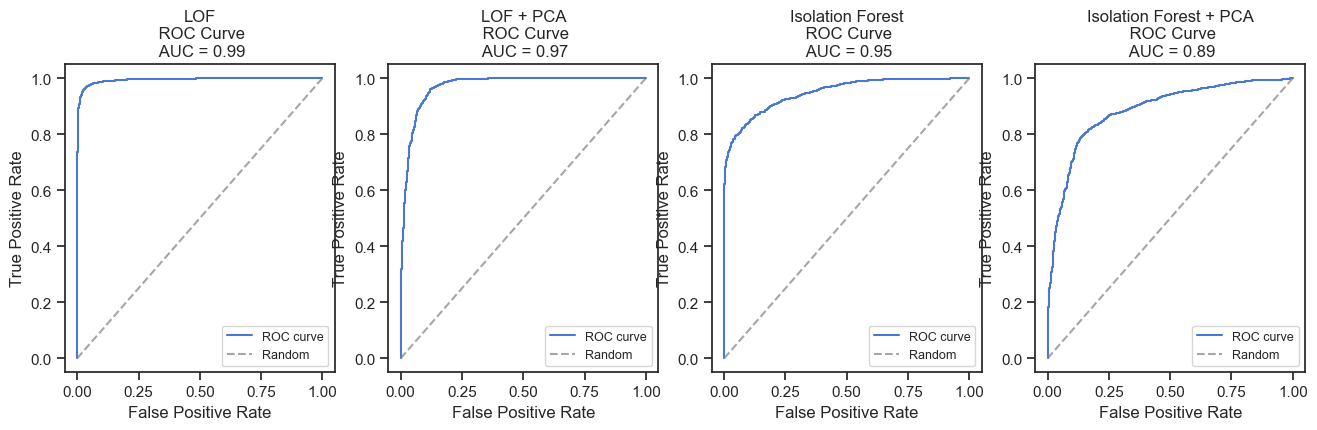

In [89]:
fan_mel_means = classify_anomalies(train_data[mel_only], test_data[mel_only], y_val, 'fan', 'mel-means')
print(fan_mel_means.to_markdown())

chroma-means features were reduced to 4 components for LOF
chroma-means features were reduced to 4 components for Isolation Forest
|    | Machine   | Features     | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | chroma-means | LOF                    | 0.982158 | 0.909679 |    0.92743  |           0.851983 |
|  1 | fan       | chroma-means | LOF + PCA              | 0.923525 | 0.735985 |    0.846816 |           0.657125 |
|  2 | fan       | chroma-means | Isolation Forest       | 0.892962 | 0.752516 |    0.845483 |           0.667096 |
|  3 | fan       | chroma-means | Isolation Forest + PCA | 0.771015 | 0.507427 |    0.760152 |           0.495088 |


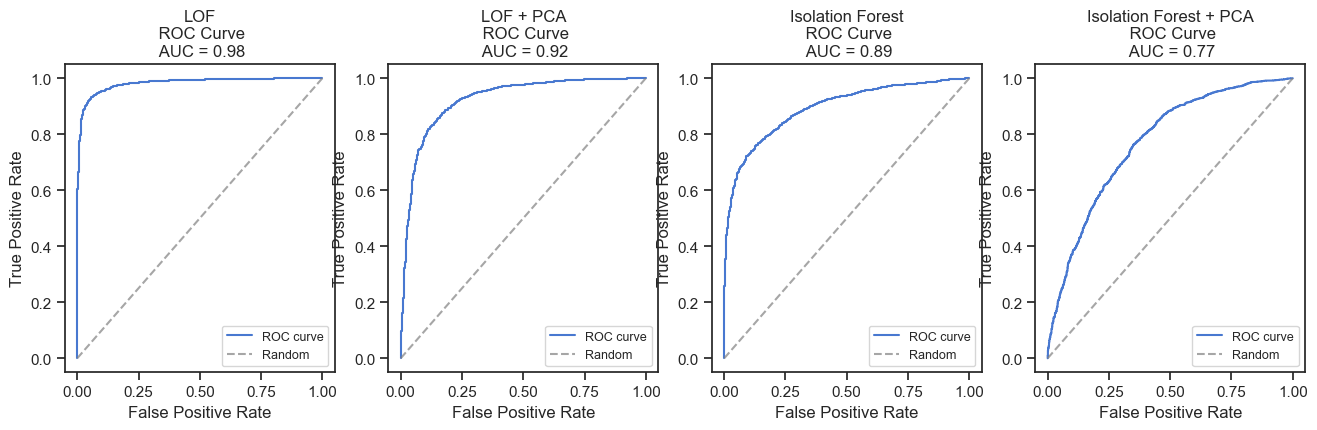

In [90]:
fan_chroma_means = classify_anomalies(train_data[chroma_only], test_data[chroma_only], y_val, 'fan', 'chroma-means')
print(fan_chroma_means.to_markdown())

All-means features were reduced to 5 components for LOF
All-means features were reduced to 5 components for Isolation Forest
|    | Machine   | Features   | Model                  |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-----------|:-----------------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | All-means  | LOF                    | 0.99597  | 0.933876 |    0.946133 |           0.889246 |
|  1 | fan       | All-means  | LOF + PCA              | 0.982478 | 0.732631 |    0.860863 |           0.663247 |
|  2 | fan       | All-means  | Isolation Forest       | 0.945388 | 0.85769  |    0.891961 |           0.779182 |
|  3 | fan       | All-means  | Isolation Forest + PCA | 0.907838 | 0.756109 |    0.84824  |           0.671401 |


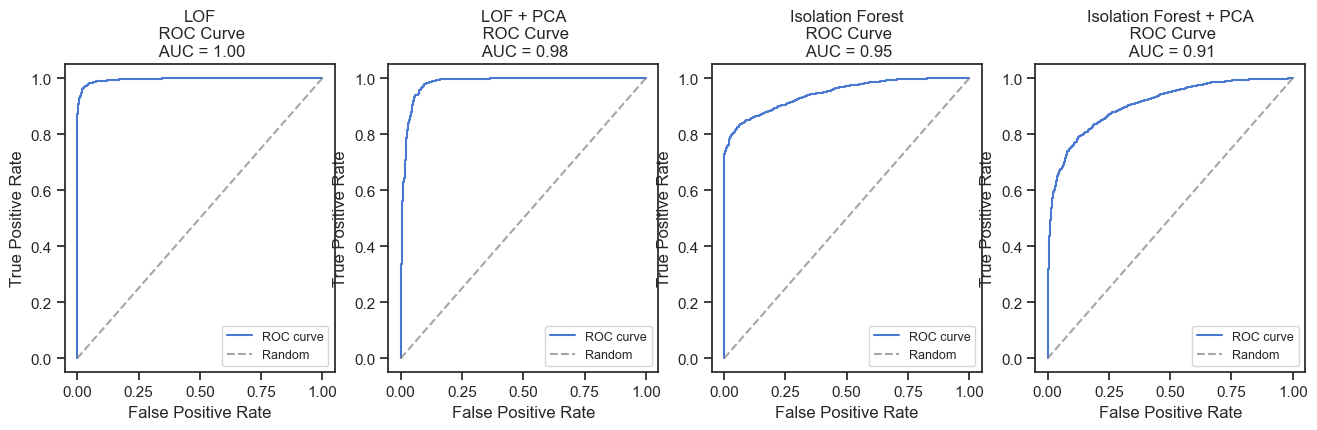

In [91]:
fan_allF_means = classify_anomalies(train_data[fancols], test_data[fancols], y_val, 'fan', 'All-means')
print(fan_allF_means.to_markdown())

# Mean vs no mean
***

In [110]:
fan_res = pd.concat([fan_allF_means, fan_chroma_means, fan_mel_means, fan_allF, fan_chroma, fan_mel], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
valve_res = pd.concat([valve_allF_means, valve_chroma_means, valve_mel_means, valve_allF, valve_chroma, valve_mel], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)

In [115]:
print('Valve machine sound classification - means v no means -  Sorted by best F1 score of the abnormal class -1')
print(valve_res.head().to_markdown())

Valve machine sound classification - means v no means -  Sorted by best F1 score of the abnormal class -1
|    | Machine   | Features     | Model     |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:----------|---------:|---------:|------------:|-------------------:|
|  0 | valve     | All-means    | LOF       | 0.665219 | 0.414323 |    0.859019 |           0.258385 |
|  8 | valve     | mel-means    | LOF       | 0.666815 | 0.402551 |    0.859777 |           0.25641  |
|  1 | valve     | All-means    | LOF + PCA | 0.641049 | 0.362982 |    0.851031 |           0.243201 |
|  9 | valve     | mel-means    | LOF + PCA | 0.618747 | 0.339111 |    0.839748 |           0.233017 |
|  4 | valve     | chroma-means | LOF       | 0.575024 | 0.292675 |    0.83062  |           0.223339 |


In [116]:
print('Fan machine sound classification - means v no means - Sorted by best F1 score of the abnormal class -1')
print(fan_res.head().to_markdown())

Fan machine sound classification - means v no means - Sorted by best F1 score of the abnormal class -1
|    | Machine   | Features     | Model            |      AUC |   Recall |   Precision |   Abnormal (-1) F1 |
|---:|:----------|:-------------|:-----------------|---------:|---------:|------------:|-------------------:|
|  0 | fan       | All-means    | LOF              | 0.99597  | 0.933876 |    0.946133 |           0.889246 |
|  8 | fan       | mel-means    | LOF              | 0.994428 | 0.927887 |    0.94199  |           0.880223 |
|  4 | fan       | chroma-means | LOF              | 0.982158 | 0.909679 |    0.92743  |           0.851983 |
|  2 | fan       | All-means    | Isolation Forest | 0.945388 | 0.85769  |    0.891961 |           0.779182 |
| 20 | fan       | mel          | LOF              | 0.947371 | 0.83517  |    0.885866 |           0.756201 |


***
# Compile All Results 
#### - incl. AE from 1-AutoEncoder_Comp.ipynb

In [133]:
AE_fan_res = pd.read_pickle('working/AE_fan_res.pkl')
AE_valve_res = pd.read_pickle('working/AE_valve_res.pkl')

In [134]:
fan_all = pd.concat([AE_fan_res, fan_res.iloc[0:5]], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)
valve_all = pd.concat([AE_valve_res, valve_res.iloc[0:5]], ignore_index=True).sort_values('Abnormal (-1) F1', ascending=False)

In [138]:
fan_all.columns = fan_all.columns.str.strip()
valve_all.columns = valve_all.columns.str.strip()

 ***

In [139]:
print('Valve machine sound classification - All models and Feature combos -  Sorted by best F1 score of the abnormal class -1')
print(valve_all.to_markdown(tablefmt="grid"))

Valve machine sound classification - All models and Feature combos -  Sorted by best F1 score of the abnormal class -1
+----+-----------+-----------+--------------+----------+-------------+----------+--------------------+
|    | Model     | Machine   | Features     |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
+====+===========+===========+==============+==========+=============+==========+====================+
|  2 | LOF       | valve     | All-means    | 0.665219 |    0.859019 | 0.414323 |           0.258385 |
+----+-----------+-----------+--------------+----------+-------------+----------+--------------------+
|  3 | LOF       | valve     | mel-means    | 0.666815 |    0.859777 | 0.402551 |           0.25641  |
+----+-----------+-----------+--------------+----------+-------------+----------+--------------------+
|  4 | LOF + PCA | valve     | All-means    | 0.641049 |    0.851031 | 0.362982 |           0.243201 |
+----+-----------+-----------+--------------+----------+-

In [140]:
print('Fan machine sound Anomaly detection - All models and Feature combos - Sorted by best F1 score of the abnormal class -1')
print(fan_all.to_markdown(tablefmt="grid"))

Fan machine sound classification - All models and Feature combos - Sorted by best F1 score of the abnormal class -1
+----+------------------+-----------+--------------+----------+-------------+----------+--------------------+
|    | Model            | Machine   | Features     |      AUC |   Precision |   Recall |   Abnormal (-1) F1 |
+====+==================+===========+==============+==========+=============+==========+====================+
|  2 | LOF              | fan       | All-means    | 0.99597  |    0.946133 | 0.933876 |           0.889246 |
+----+------------------+-----------+--------------+----------+-------------+----------+--------------------+
|  3 | LOF              | fan       | mel-means    | 0.994428 |    0.94199  | 0.927887 |           0.880223 |
+----+------------------+-----------+--------------+----------+-------------+----------+--------------------+
|  4 | LOF              | fan       | chroma-means | 0.982158 |    0.92743  | 0.909679 |           0.851983 |
+---